In [1]:
import csv
from collections import defaultdict
from constants import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

import warnings     #filter warnings for clean notebook output
warnings.filterwarnings('ignore')

In [2]:
valid_users = set()
user_train_count = defaultdict(int)     # number of training grids completed for each user
user_test_count = defaultdict(int)      # number of test grids completed for each user
user_train_score = defaultdict(int)     # cumulative training score for each user
user_test_timeouts = defaultdict(set)   # test grids the user timed out on for each user

with open('data/time_pressure_experiment_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['step'] == '6':          # step 6 contains metadata for the trial as a whole including total reward
            user = row['userid']
            valid_users.add(user)
            if row['type'] == "train":
                user_train_count[user] += 1
                user_train_score[user] += int(row['reward_cum'])
            elif row['type'] == "test":
                user_test_count[user] += 1
                if int(row['gridnum']) > 100 and int(row['reward_cum']) <= -4:    # If score <=-4 on test grids of interest, we know the user timed out
                    user_test_timeouts[user].add(int(row['gridnum']))

# exclude users who did not complete all training and test grids, scored less than 0 points in training, or timed out 6 or more times
def include_user(user):
    return not (user_train_count[user]!=60 or user_test_count[user]!=50 or len(user_test_timeouts[user])>=6 or user_train_score[user]<0)

print("Number of users before exclusions: " + str(len(valid_users)))       
valid_users = set(filter(include_user, valid_users))
print("Number of users after exclusions: " + str(len(valid_users)))

Number of users before exclusions: 232
Number of users after exclusions: 136


In [4]:
df = pd.read_csv('data/time_pressure_experiment_raw.csv', encoding='utf-8-sig') 
df['userid'] = df['userid'].apply(str)
filtered = df[(df['userid'].isin(valid_users))]
filtered.to_csv('data/time_pressure_data_after_exclusions.csv')
filtered = filtered[(df['step']==6) & (df['type']=='train')]
filtered['correct'] = filtered['reward_cum'] == filtered['reward_max']
training_accuracy = filtered['correct'].mean()
print("training accuracy", training_accuracy)

training accuracy 0.8004901960784314


The following block writes preprocessed data (with exclusions removed and with variables coded as described in the pre-registration) to a csv to be used in downstream R processing.

In [5]:
best_score_count = defaultdict(int)     # The number of grids where the user achieved the best score for each grid type and manipulation
total_count = defaultdict(int)          # The total number of grids completed for each grid type and manipulation
data = []

with open('data/time_pressure_experiment_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        gridnum = int(row['gridnum'])
        userid = row['userid']
        # looks only at final results for test grids of interest where user did not time out
        #user_grids = set(first_three[first_three['userid']==str(userid)]['gridnum'])
        if userid in valid_users and gridnum > 100 and not gridnum in user_test_timeouts[userid] and row['step']=='6':
            score_dif = int(row['reward_cum'])-int(row['reward_max'])
            timed = int(row['timed'])
            if timed == 0:
                time = 0.5 #delay
            else:
                time = -0.5 #pressure
            if gridnum in MUST_PUSH_GRIDNUMS: 
                distrib = -0.5 #out of distrib
                push_val = 0.5
            elif gridnum in MUST_SWITCH_GRIDNUMS:
                distrib = -0.5 #out of distrib        
                push_val = -0.5
            elif gridnum in PUSH_GET_GRIDNUMS:
                distrib = 0.5 #in distrib
                push_val = 0
            elif gridnum in SWITCH_SAVE_GRIDNUMS:
                distrib = 0.5 #in distrib
                push_val = 0

            bin_num = (gridnum//100-1)*2 + timed    # assign a bin for each unique gridtype and time constraint combination
            if score_dif == 0:
                best_score_count[bin_num] += 1
            total_count[bin_num] += 1

            data.append([userid, gridnum, score_dif, time, distrib, time*distrib, push_val, time*push_val])

df = pd.DataFrame(data,columns=['user_id', 'grid_num', 'score_dif', 'time_constraint', 'in_distrib', 'time_x_distrib', 'push', 'time_x_push'])
df.to_csv('data/time_pressure_data_coded.csv')

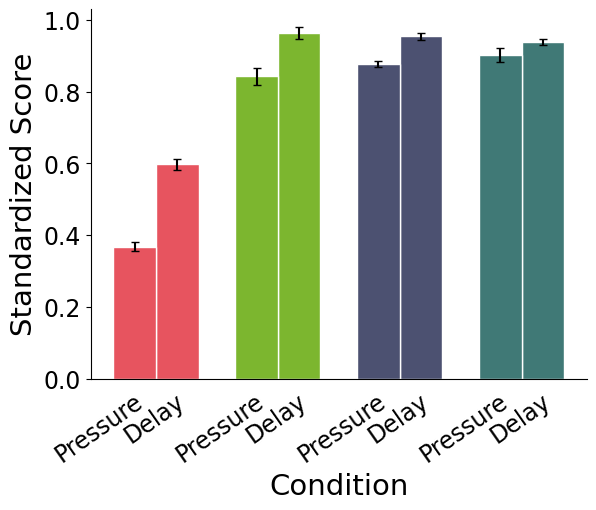

In [6]:
# Compute proportion of grids on which the best score was achieved 
proportion = {}
for bin_num, count in best_score_count.items():
    proportion[bin_num] = count/total_count[bin_num]

# Compute standard error of mean
sem = []
for bin_num, count in best_score_count.items():
    x = np.concatenate((np.zeros(total_count[bin_num]-count),np.ones(count)))
    sem.append(scipy.stats.sem(x))
    
# Define labels, positions, bar heights and error bar heights
labels = ['Pressure', 'Delay','Pressure', 'Delay','Pressure', 'Delay','Pressure', 'Delay',]
delay_proportions = []
delay_error = []
pressure_proportions = []
pressure_error = []
for i in range(8):
    if i%2==0:
        delay_proportions.append(proportion[i])
        delay_error.append(sem[i])
    else:
        pressure_proportions.append(proportion[i])
        pressure_error.append(sem[i])

x = np.arange(4)  # the label locations
width = 0.35  # the width of the bars
color=['#E7545F', '#7CB62F', '#4C5171','#407976']
plt.rcParams.update({'font.size': 21})

fig, ax = plt.subplots()
rects1 = ax.bar(x + width/2, delay_proportions, width, yerr=delay_error, capsize=3, label='Delay', color=color, edgecolor='white')
rects2 = ax.bar(x - width/2, pressure_proportions, width, yerr=pressure_error, capsize=3, label='Pressure', color=color, edgecolor='white')

ax.set_ylabel('Standardized Score')
ax.set_xticks(np.array([-.175,0.175,.825,1.175,1.825,2.175,2.825,3.175])+.1)
ax.set_xticklabels(labels)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
ax.set_xlabel('Condition')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tick_params(
    axis='both',         
    which='both',     
    bottom=False)
plt.setp(ax.get_xticklabels(), rotation=35, horizontalalignment='right')

plt.show()


In [7]:
labels = ['Push','Switch','Switch Control','Push Control']
print("Proportion of best score achieved out of total completed:")
for idx, p in enumerate(delay_proportions):
    print("Delay " + labels[idx] + ": " + '{:.1%}'.format(p))
for idx, p in enumerate(pressure_proportions):
    print("Pressure " + labels[idx] + ": " + '{:.1%}'.format(p))

Proportion of best score achieved out of total completed:
Delay Push: 59.7%
Delay Switch: 96.3%
Delay Switch Control: 95.5%
Delay Push Control: 93.8%
Pressure Push: 36.9%
Pressure Switch: 84.3%
Pressure Switch Control: 87.6%
Pressure Push Control: 90.2%


In [8]:
#Creating data for supplemental analysis in R
best_score_count = defaultdict(int)     # The number of grids where the user achieved the best score for each grid type and manipulation
total_count = defaultdict(int)          # The total number of grids completed for each grid type and manipulation
data = []

with open('data/time_pressure_experiment_raw.csv', encoding='utf-8-sig') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        gridnum = int(row['gridnum'])
        userid = row['userid']
        # looks only at final results for test grids of interest where user did not time out
        #user_grids = set(first_three[first_three['userid']==str(userid)]['gridnum'])
        if userid in valid_users and gridnum > 100 and not gridnum in user_test_timeouts[userid] and row['step']=='6' and (gridnum in MUST_PUSH_GRIDNUMS or gridnum in MUST_SWITCH_GRIDNUMS):
            score_dif = int(row['reward_cum'])-int(row['reward_max'])
            timed = int(row['timed'])
            if timed == 0:
                time = 0.5 #delay
            else:
                time = -0.5 #pressure
            if gridnum in MUST_PUSH_GRIDNUMS: 
                distrib = -0.5 #out of distrib
                push_val = 0.5
            elif gridnum in MUST_SWITCH_GRIDNUMS:
                distrib = -0.5 #out of distrib        
                push_val = -0.5
         
            bin_num = (gridnum//100-1)*2 + timed    # assign a bin for each unique gridtype and time constraint combination
            if score_dif == 0:
                best_score_count[bin_num] += 1
            total_count[bin_num] += 1

            data.append([userid, gridnum, score_dif, time, distrib, time*distrib, push_val, time*push_val])

df = pd.DataFrame(data,columns=['user_id', 'grid_num', 'score_dif', 'time_constraint', 'in_distrib', 'time_x_distrib', 'push', 'time_x_push'])
df.to_csv('data/time_pressure_data_pushswitchonly_coded.csv')